# TCC Memory: Scaling physical qubits

## Setup

In [1]:
import numpy as np
from typing import List, Dict
import functools
import itertools
import dataclasses

import pickle 
import cirq
from mitiq import PauliString
import stim
import stimcirq
from qiskit.quantum_info import StabilizerState


from encoded.diagonalize import get_stabilizer_matrix_from_paulis, get_measurement_circuit_tcc, get_paulis_from_stabilizer_matrix

## Set experiment parameters

## Helper functions

In [3]:
def int_to_bin_list(x, length):
    result = [0] * length
    for i in range(length):
        if x & (1 << i):
            result[length - 1 - i] = 1
    return result

def int_to_bin_str(x, length):
    return functools.reduce(lambda a, b: a + b, [str(b) for b in int_to_bin_list(x, length)])

def compute_expectation(
    pauli: cirq.PauliString,
    counts: Dict[str, int],
) -> float:
    if pauli is cirq.PauliString():
        return 1.0

    expectation = 0.0

    indices = [q.x for q in pauli.qubits]
    for key, value in counts.items():
        key = list(map(int, list(key)))
        expectation += (-1) ** sum([key[i] for i in indices]) * value
    return expectation / sum(counts.values())

def noisy_identity(qreg, depth, noise) -> cirq.Circuit:
    circuit = cirq.Circuit()
    if depth == 0:
        circuit.append(cirq.I.on_each(qreg))
    for _ in range(depth):
        circuit.append(cirq.X.on_each(qreg))

    return circuit.with_noise(noise)

def strs_to_paulis(pauli_strs : List[str]) -> List[cirq.PauliString]:
    stab_list = []
    for stab_str in pauli_strs:
        stab_list.append(PauliString(stab_str)._pauli)
    return stab_list


def measure_observable(
    pauli: cirq.PauliString,
    bitstring: str,
) -> float:
    if pauli is cirq.PauliString():
        return 1.0

    indices = [q.x for q in pauli.qubits]
    bitstring = list(map(int, list(bitstring[::-1])))
    return (-1) ** sum([bitstring[i] for i in indices])


def generate_stabilizer_elements(generators: List[cirq.PauliString]) -> List[cirq.PauliString]:
    elements = []
    for string in itertools.chain.from_iterable(itertools.combinations(generators, r) for r in range(len(generators) + 1)):
        elements.append(
            functools.reduce(lambda a, b: a * b, string, cirq.PauliString())
        )
    return elements


def process(bitstring, count, elements,nshots):
    n_elements = len(elements)

    values = [measure_observable(pauli, bitstring) for pauli in elements]
    qubit_ev = sum(values)
    m = qubit_ev / n_elements
    return m * count / nshots

### Logical state preparation / encoding

In [4]:
@dataclasses.dataclass
class Tile:
    qubits: list
    color: str


def make_color_code_tiles(*, base_data_width):
    if not (base_data_width % 2 == 1 and base_data_width >= 3):
        raise ValueError(f"{base_data_width=} wasn't an odd number at least as large as 3.")
    w = base_data_width * 2 - 1

    def is_in_bounds(q: complex) -> bool:

        if q.imag < 0:

            return False
        if q.imag * 2 > q.real * 3:

            return False
        if q.imag * 2 > (w - q.real) * 3:

            return False
        return True


    tiles = []
    hexagon_offsets = [-1, +1j, +1j + 1, +2, -1j + 1, -1j]
    for x in range(1, w, 2):
        for y in range((x // 2) % 2, w, 2):
            q = x + 1j * y

            tile = Tile(
                color=['red', 'green', 'blue'][y % 3],

            
                qubits=[
                    q + d
                    for d in hexagon_offsets
                    if is_in_bounds(q + d)
                ],
            )

            if len(tile.qubits) in [4, 6]:
                tiles.append(tile)

    return tiles

def get_stabilizer_generators(distance: int):
    tiles = make_color_code_tiles(base_data_width=distance)
    all_qubits = {q for tile in tiles for q in tile.qubits}

    # Only difference here is with the chromobius notebook that we rever
    sorted_qubits = reversed(sorted(all_qubits, key=lambda q: (q.imag, q.real)))
    q2i = {q: i for i, q in enumerate(sorted_qubits)}

    sorted_tiles = []
    for tile in tiles:
        sorted_tiles.append([q2i[q] for q in tile.qubits])

    stabilizers_x = []
    stabilizers_z = []
    for tile in sorted_tiles:
        stab_x = ""
        stab_z = ""
        for i in range(int((3*distance**2+1)/4)):
            if i in tile:
                stab_x+="X"
                stab_z+="Z"
            else:
                stab_x+="I"
                stab_z+="I"
        stabilizers_x.append(stab_x)
        stabilizers_z.append(stab_z)

    return stabilizers_x + stabilizers_z

def stabilizers_to_encoder(stabilizers) -> stim.Circuit:
    
    tableau = stim.Tableau.from_stabilizers(
        stabilizers,
        allow_underconstrained=True,
    )
    # Note: Look at https://github.com/quantumlib/Stim/blob/main/doc/python_api_reference_vDev.md
    # For the different method of encoding

    return tableau.to_circuit(method='graph_state')



## Set parameters

In [103]:
distance = 3
nshots = 5_000_000 # number of repetitions to run circuit

simulator = stimcirq.StimSampler()

noise_rate = 0.001
noise = cirq.depolarize
PAULI_O = "Z"

## Run encoded experiment

In [104]:
generator_strs = get_stabilizer_generators(distance)[::-1]
n = len(generator_strs[0])


observable = PauliString(PAULI_O*n)._pauli

qreg = cirq.LineQubit.range(n)
stabilizer_generators = strs_to_paulis(generator_strs)
stabilizer_matrix = get_stabilizer_matrix_from_paulis(stabilizer_generators, qreg)
encoding_circuit = stimcirq.stim_circuit_to_cirq_circuit(stabilizers_to_encoder([stim.PauliString(s) for s in generator_strs]))

In [105]:
circuit = encoding_circuit 
circuit = circuit.with_noise(noise(noise_rate))
circuit.append(cirq.measure(qreg, key="z"))
circuit

┌──┐                         ┌──┐
0: ───RX───D(0.001)[<virtual>]───@───D(0.001)[<virtual>]───@───D(0.001)[<virtual>]────@─────D(0.001)[<virtual>]──────────D(0.001)[<virtual>]───────D(0.001)[<virtual>]───────D(0.001)[<virtual>]───────D(0.001)[<virtual>]───H───D(0.001)[<virtual>]───M('z')───
                                 │                         │                          │                                                                                                                                                                │
1: ───RX───D(0.001)[<virtual>]───┼───D(0.001)[<virtual>]───┼───D(0.001)[<virtual>]────┼@────D(0.001)[<virtual>]────@─────D(0.001)[<virtual>]───────D(0.001)[<virtual>]───────D(0.001)[<virtual>]───────D(0.001)[<virtual>]───H───D(0.001)[<virtual>]───M────────
                                 │                         │                          ││                           │                                                                                                                                   │
2: ───RX───D(0.001)[<virtual>]───┼───D(0.001)[<virtual>]───┼───D(0.001)[<virtual>]────┼┼────D(0.001)[<virtual>]────┼@────D(0.001)[<virtual>]───@───D(0.001)[<virtual>]───────D(0.001)[<virtual>]───────D(0.001)[<virtual>]───H───D(0.001)[<virtual>]───M────────
                                 │                         │                          ││                           ││                          │                                                                                                       │
3: ───RX───D(0.001)[<virtual>]───@───D(0.001)[<virtual>]───┼───D(0.001)[<virtual>]────┼@────D(0.001)[<virtual>]────┼@────D(0.001)[<virtual>]───┼───D(0.001)[<virtual>]───────D(0.001)[<virtual>]───────D(0.001)[<virtual>]───────D(0.001)[<virtual>]───M────────
                                                           │                          │                            │                           │                                                                                                       │
4: ───RX───D(0.001)[<virtual>]───────D(0.001)[<virtual>]───@───D(0.001)[<virtual>]────┼─────D(0.001)[<virtual>]────┼─────D(0.001)[<virtual>]───@───D(0.001)[<virtual>]───@───D(0.001)[<virtual>]───────D(0.001)[<virtual>]───────D(0.001)[<virtual>]───M────────
                                                                                      │                            │                                                     │                                                                             │
5: ───RX───D(0.001)[<virtual>]───────D(0.001)[<virtual>]───────D(0.001)[<virtual>]────@─────D(0.001)[<virtual>]────@─────D(0.001)[<virtual>]───────D(0.001)[<virtual>]───┼───D(0.001)[<virtual>]───@───D(0.001)[<virtual>]───────D(0.001)[<virtual>]───M────────
                                                                                                                                                                         │                         │                                                   │
6: ───RX───D(0.001)[<virtual>]───────D(0.001)[<virtual>]───────D(0.001)[<virtual>]──────────D(0.001)[<virtual>]──────────D(0.001)[<virtual>]───────D(0.001)[<virtual>]───@───D(0.001)[<virtual>]───@───D(0.001)[<virtual>]───H───D(0.001)[<virtual>]───M────────
                                                                                     └──┘                         └──┘

In [106]:
counts = simulator.run(circuit, repetitions=nshots).histogram(key="z")
counts = {int_to_bin_str(key, n) : val for key, val in counts.items()}

## Post-processing

In [107]:
logical0 = StabilizerState.from_stabilizer_list(generator_strs+["Z"*n]).probabilities_dict()
logical1 = [s.replace('1', '2').replace('0', '1').replace('2', '0') for s in logical0]

In [108]:
p0 = 0.0
p1 = 0.0
for state in logical0:
    if state in counts:
        p0 += counts[state]
for state in logical1:
    if state in counts:
        p1 += counts[state]
obs_value = (p0-p1)/(p0+p1)
obs_value

0.9999846272130322

# Scaling experiment Z

### Unencoded

In [181]:
d_set = [3,5]
nshots = 100_000_000 # number of repetitions to run circuit

simulator = stimcirq.StimSampler()

noise_set = np.logspace(-4,-2,10)
noise = cirq.depolarize

PAULI_O = "Z"

In [178]:

obs_unencoded = []
for noise_ratio in noise_set:
    circuit_unencoded = cirq.Circuit()
    qubits = cirq.LineQubit.range(1)
    circuit_unencoded.append(cirq.I(qubits[0]))
    circuit_unencoded = circuit_unencoded.with_noise(noise(noise_ratio))
    circuit_unencoded.append(cirq.measure(qubits, key="z"))
    counts = simulator.run(circuit_unencoded, repetitions=nshots).histogram(key="z")
    counts = {int_to_bin_str(key, 1) : val for key, val in counts.items()}
    obs_unencoded.append(counts["0"]-counts["1"])

### Encoded

In [182]:

PAULI_O = "Z"
d_set = [3,5]
generator_strs_list = [get_stabilizer_generators(distance)[::-1] for distance in d_set]
n_set = [len(generator_str[0]) for generator_str in generator_strs_list]
obs_set = [PauliString(PAULI_O*n)._pauli for n in n_set]
logical0_set = [StabilizerState.from_stabilizer_list(generator_strs_list[i]+["Z"*n_set[i]]).probabilities_dict() for i in range(len(d_set))]
logical1_set = [[s.replace('1', '2').replace('0', '1').replace('2', '0') for s in logical0]for logical0 in logical0_set]


with open('codewords0.pkl', 'wb') as f:
    pickle.dump(logical0_set, f)
with open('codewords1.pkl', 'wb') as f:
    pickle.dump(logical1_set, f)

In [183]:
results_raw = {}
results_post_process = {}

for i in range(len(d_set)):
    results_raw[d_set[i]] = {}
    results_post_process[d_set[i]] = {}

    for noise_ratio in noise_set:

        # circuit preparation
        generator_strs = get_stabilizer_generators(d_set[i])
        observable = PauliString(PAULI_O*n_set[i])._pauli
        qreg = cirq.LineQubit.range(n_set[i])
        stabilizer_generators = strs_to_paulis(generator_strs_list[i])
        stabilizer_matrix = get_stabilizer_matrix_from_paulis(stabilizer_generators, qreg)
        encoding_circuit = stimcirq.stim_circuit_to_cirq_circuit(stabilizers_to_encoder([stim.PauliString(s) for s in generator_strs_list[i]]))
        encoding_circuit = encoding_circuit.with_noise(noise(noise_ratio))
        encoding_circuit.append(cirq.measure(qreg, key="z"))
        # running circuit
        counts = simulator.run(encoding_circuit, repetitions=nshots).histogram(key="z")
        counts = {int_to_bin_str(key, n_set[i]) : val for key, val in counts.items()}
        results_raw[d_set[i]][noise_ratio] = counts
        # post-processing
        p0 = 0.0
        p1 = 0.0
        for state in logical0_set[i]:
            if state in counts:

                p0 += counts[state]
        for state in logical1_set[i]:
            if state in counts:
                p1 += counts[state]
        obs_value = (p0-p1)/(p0+p1)
        results_post_process[d_set[i]][noise_ratio] = obs_value

        # saving
        print("d = " + str(d_set[i])+ " noise = "+str(noise_ratio) + " expect = "+str(obs_value))
        with open('raw_results_Z.pkl', 'wb') as f:
            pickle.dump(results_raw, f)
        with open('post_process_results_Z.pkl', 'wb') as f:
            pickle.dump(results_post_process, f)

d = 3 noise = 0.0001 expect = 0.9999998193153062
d = 3 noise = 0.0001668100537200059 expect = 0.9999997383504751
d = 3 noise = 0.0002782559402207126 expect = 0.9999990298045458
d = 3 noise = 0.00046415888336127773 expect = 0.9999972519844743
d = 3 noise = 0.000774263682681127 expect = 0.9999924412828503
d = 3 noise = 0.001291549665014884 expect = 0.9999763922980881
d = 3 noise = 0.002154434690031882 expect = 0.9999262346419847
d = 3 noise = 0.003593813663804626 expect = 0.9997708617387906
d = 3 noise = 0.005994842503189409 expect = 0.9992301082330001
d = 3 noise = 0.01 expect = 0.9972533974459912
d = 5 noise = 0.0001 expect = 1.0
d = 5 noise = 0.0001668100537200059 expect = 1.0
d = 5 noise = 0.0002782559402207126 expect = 0.9999999776489021
d = 5 noise = 0.00046415888336127773 expect = 0.9999997833933245
d = 5 noise = 0.000774263682681127 expect = 0.999999129356024
d = 5 noise = 0.001291549665014884 expect = 0.9999960654693234
d = 5 noise = 0.002154434690031882 expect = 0.9999734585499

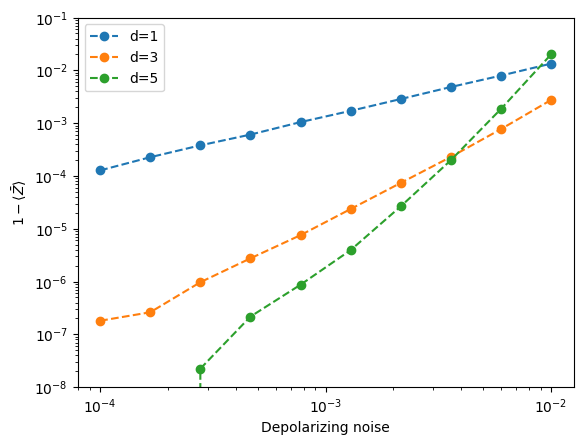

In [198]:
import matplotlib.pyplot as plt
plt.figure()
plt.loglog(list(results_post_process[3].keys()),np.ones(1)-obs_unencoded/(10_000_000*np.ones(10)),"--o",label = "d=1")
plt.loglog(list(results_post_process[3].keys()),np.ones(1)-list(results_post_process[3].values()),"--o",label = "d=3")
plt.loglog(list(results_post_process[5].keys()),np.ones(1)-list(results_post_process[5].values()),"--o",label = "d=5")
plt.ylim(1e-8,1e-1)
plt.xlabel("Depolarizing noise")
plt.ylabel(r"$1-\langle \bar{Z} \rangle$")
plt.legend()

# Scaling experiment X

obs_unencoded

In [ ]:
obs_unencoded[0]/10_000_000

0.9998728